# Plots

Train and evaluate the model on the whole system(rectifier) and each capacitor(isolated or on the system)

In [1]:
import numpy as np
import sys
sys.path.append('./data')
from datautil import sys_separation
from evalutil import plot_fig,error_plot,scoring 
import matplotlib.pyplot as plt 

# Address info

In [2]:
data='Rectifier'#'-Rectifier_ripple'#'-RectifierDiode_norm3' #  #'RectifierRUL'#'Rectifier_ripple_Vpp'#'Rectifier_ripple'#'RectifierRUL'#'Capacitor'### #_red200' # 
dataset_name='Rectifier'#'Rectifier'#'Capacitor12'#
exp='overall3' #'overall_noisy'

exp_address=f'./Experiments/{data}/{dataset_name}_{exp}'
exp_auto_address=exp_address+f'/autoregressive_test'
folder=exp_auto_address

In [17]:
embedding_dimension=5
folder='./Experiments/Rectifier/Rectifier_overall3'+f'/latent_dim{embedding_dimension}'
epoch=21
RMSE_mean=39.46403481966571
threshold=0.003


# RMSE_mean=94.28178981336194
# threshold=0.014999999999999994

In [18]:
#y_pred=np.load(f'{folder}/y_pred_Test_{RMSE_mean}_{threshold}.npy')

y_pred=np.load(f'{folder}/y_pred_{RMSE_mean}_epoch{epoch}_{threshold}.npy')

## Load Predictions

In [20]:

y_true=np.load(f'{folder}/y_true.npy')
sys_array=np.load(f'{folder}/y_sys_array.npy')

# y_true=np.load(f'{folder}/y_true_test.npy')
# sys_array=np.load(f'{folder}/y_sys_test.npy')

y_pred_sep=sys_separation(y_pred,sys_array) 
y_true_sep=sys_separation(y_true,sys_array)   

## Evaluate the model

In [21]:
#Evaluate metric
RMSE_sys=np.sqrt(np.nanmean((y_pred_sep-y_true_sep)**2,axis=1))
RMSE_mean=np.mean(RMSE_sys,axis=0)
RMSE_std=np.std(RMSE_sys,axis=0)

#scoring=met.LPBP(a=10,b=13)
scoring_sys=np.nanmean(scoring(y_pred_sep,y_true_sep),axis=1)
#scoring_sys=np.nanmean(np.array(scoring(torch.tensor(y_true),torch.tensor(y_pred))),axis=1)
scoring_mean=np.nanmean(scoring_sys,axis=0)
scoring_std=np.nanstd(scoring_sys,axis=0)

score_sys=0.5*RMSE_sys+0.5*scoring_sys
score_mean=np.mean(score_sys)
score_std=np.std(score_sys)


# MAE_sys=np.nanmean(abs(y_pred-y_true),axis=1)
# MAE_mean=np.nanmean(MAE_sys,axis=0)
# MAE_std=np.nanstd(MAE_sys,axis=0)


print(f'------------ ------------')

print(f'RMSE_mean: {RMSE_mean}')
print(f'RMSE_std: {RMSE_std}') 
print(f'Scoring Mean: {scoring_mean}')
print(f'Scoring Std: {scoring_std}')
print(f'score Mean: {score_mean}')
print(f'score Std: {score_std}')
print(f'------------ {0.5*RMSE_mean+0.5*scoring_mean} ------------')


------------ ------------
RMSE_mean: 36.778431193819955
RMSE_std: 14.30933412738829
Scoring Mean: 8462.381164690625
Scoring Std: 114291.87667477287
score Mean: 4249.5797979422205
score Std: 57148.12476771911
------------ 4249.579797942222 ------------


# Plots

In [22]:
n_sys=y_true_sep.shape[0]
life=y_true_sep.shape[1]
xlabel='RUL(100h)'
eval_start=0

# Error Plot

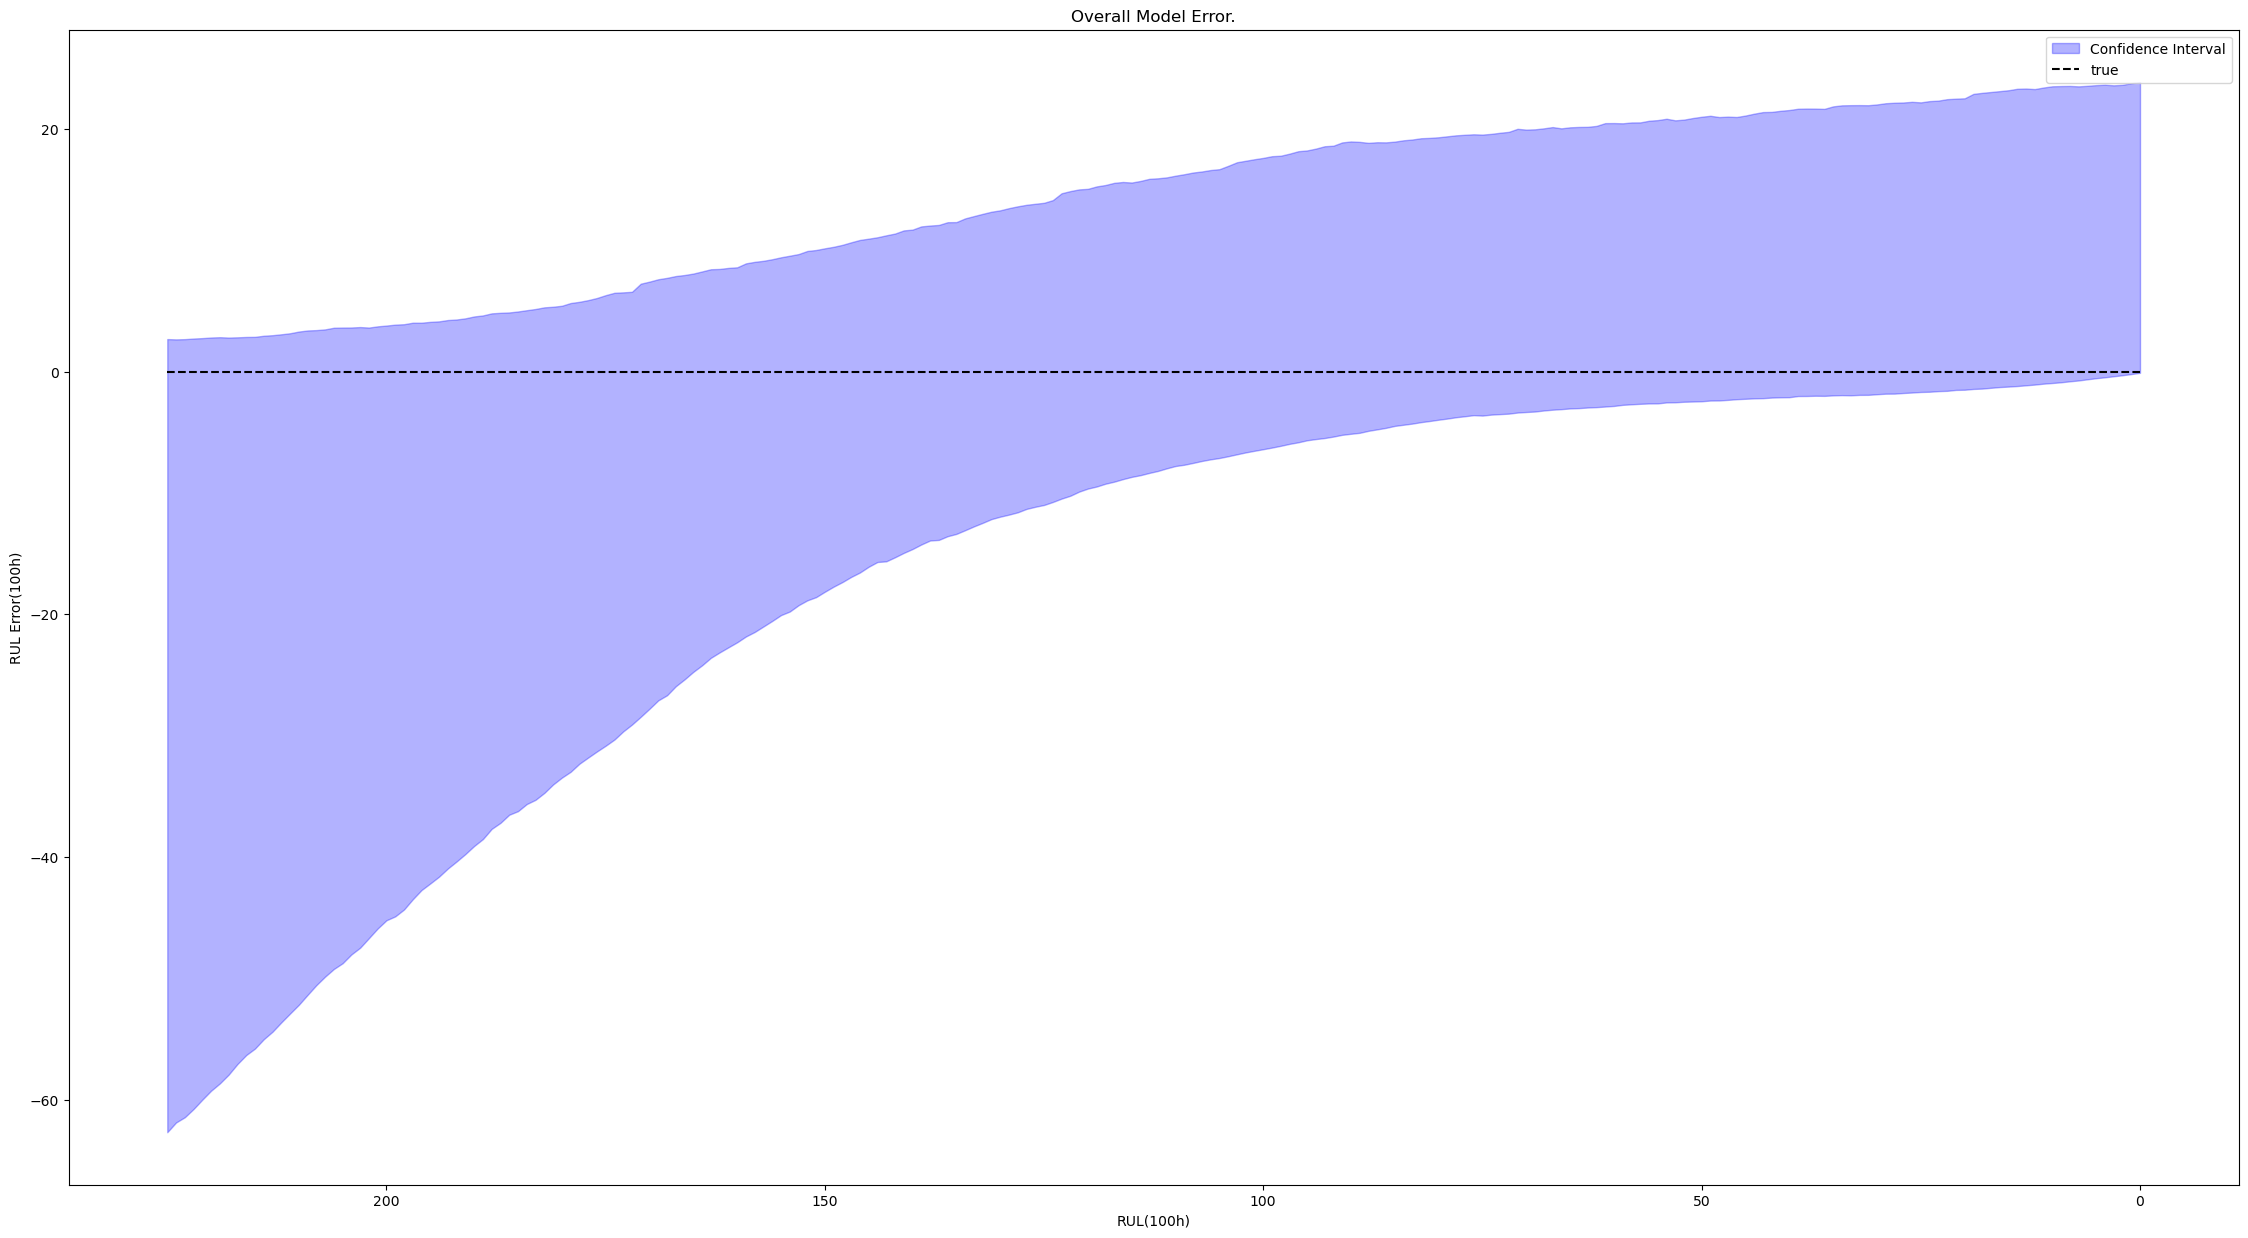

In [23]:
true_zero=np.zeros(life)
error_under,error_over=error_plot(y_pred_sep,y_true_sep)   
under=np.nanmean(error_under,axis=0)
over=np.nanmean(error_over,axis=0)
title=f'Overall Model Error.'    
ylabel='RUL Error(100h)'
plot_fig(eval_start,title,xlabel,ylabel,plots={'true':true_zero, 'lower_std':under,'upper_std':over})

## Average plot

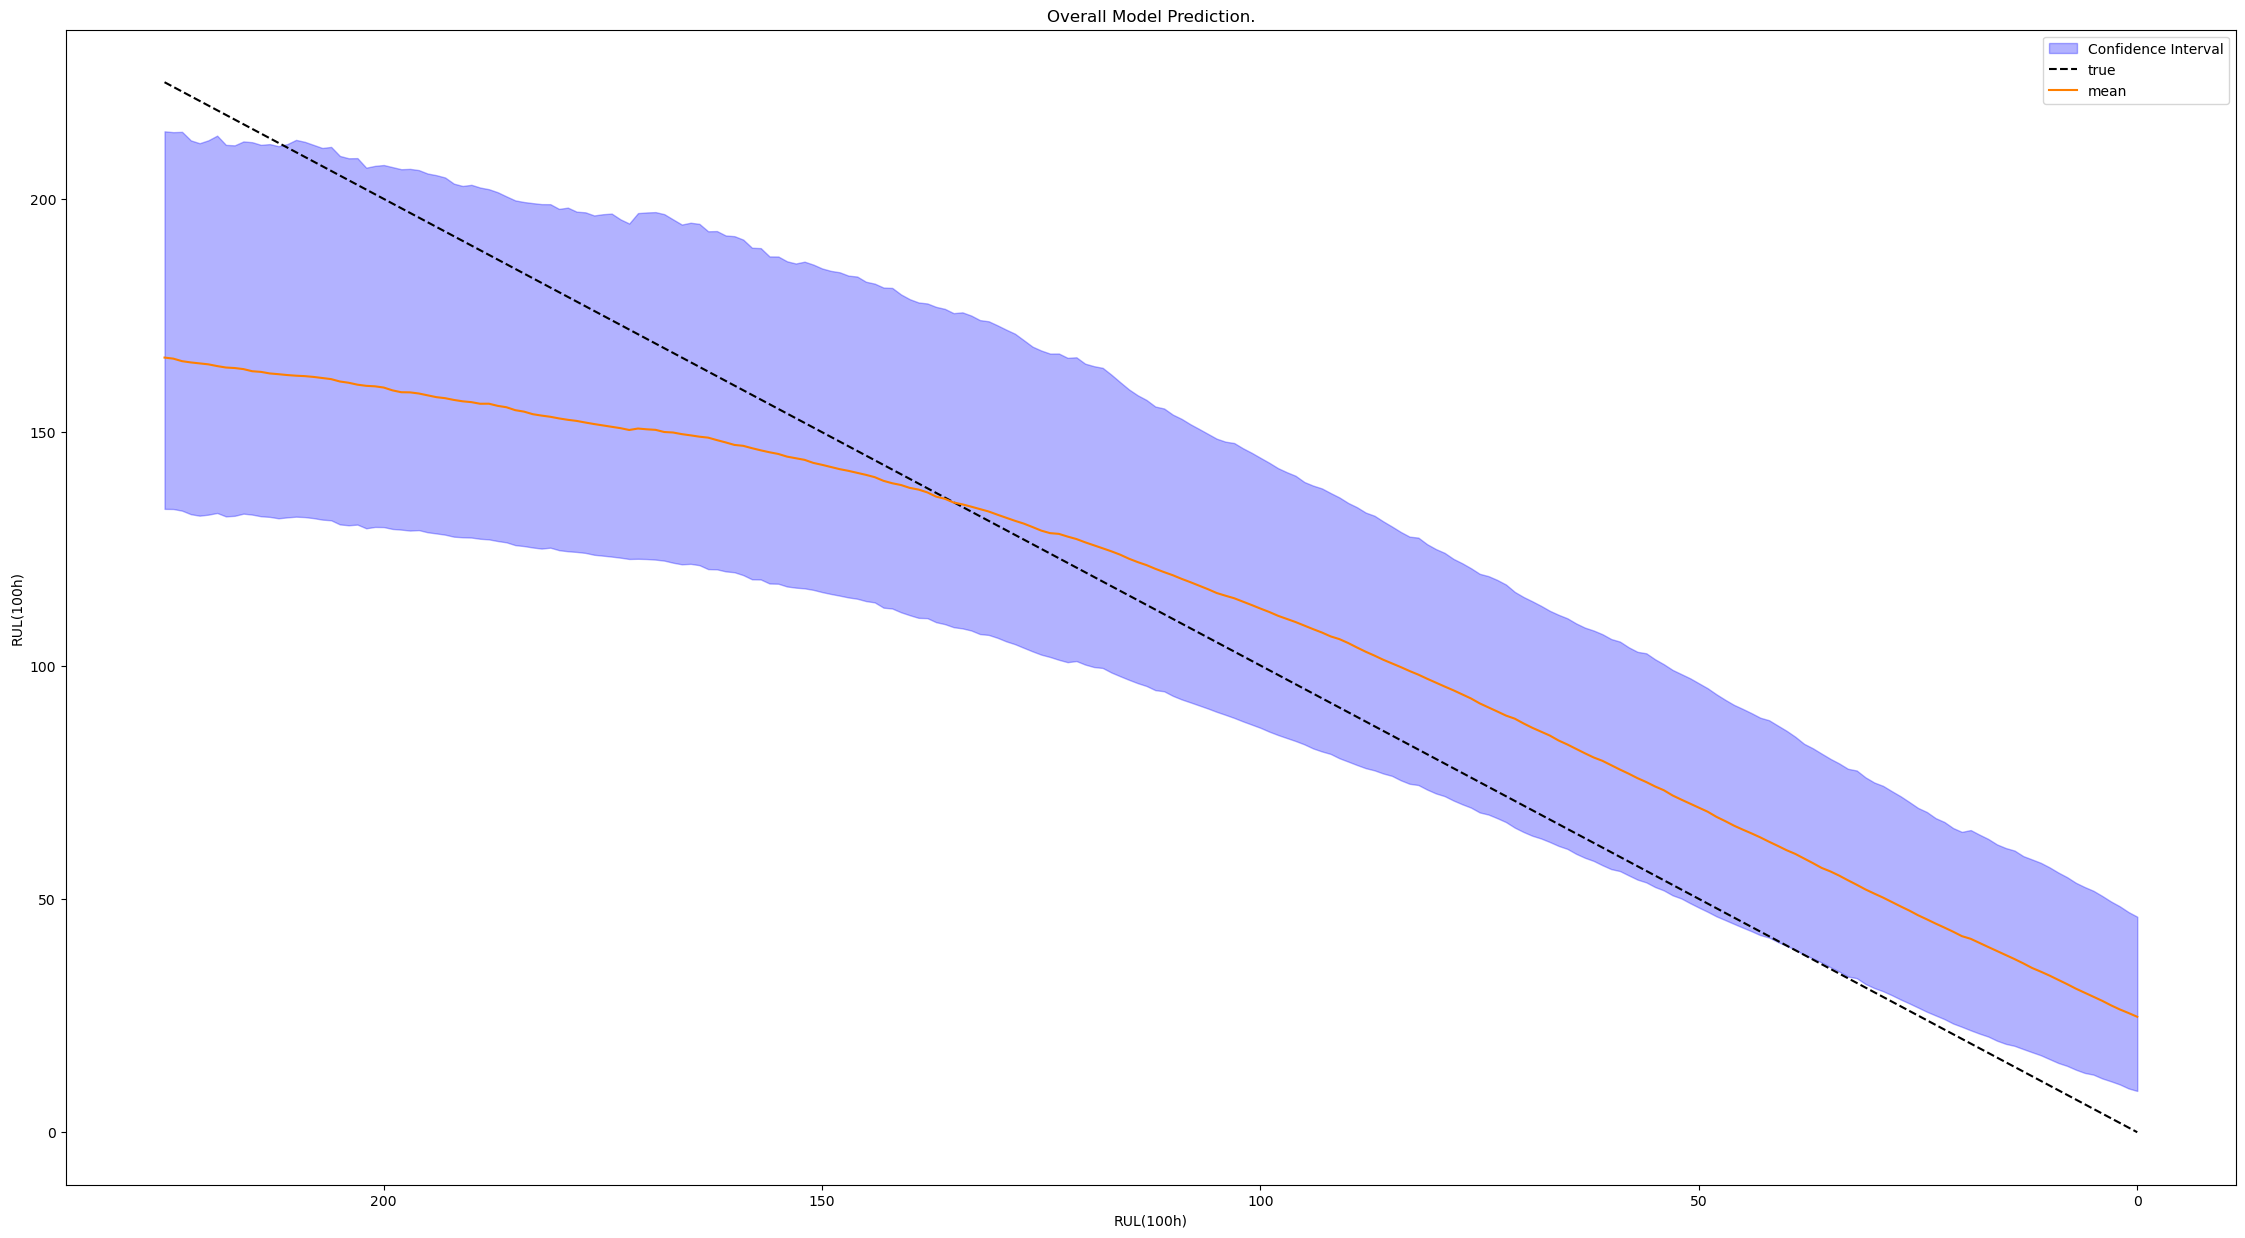

In [24]:
true=np.array(range(life-1,-1,-1))
mean=np.nanmean(y_pred_sep,axis=0)
#std=np.nanstd(y_pred,axis=0)
overpred=y_pred_sep.copy()
underpred=y_pred_sep.copy()
overpred[y_pred_sep<mean]=np.nan
underpred[y_pred_sep>mean]=np.nan
overstd=np.sqrt(np.nanmean((overpred-mean)**2,axis=0))
understd=np.sqrt(np.nanmean((underpred-mean)**2,axis=0))
title=f'Overall Model Prediction.'
ylabel='RUL(100h)'
plot_fig(eval_start,title,xlabel,ylabel,plots={'true':true, 'mean':mean,'lower_std':mean+overstd,'upper_std':mean-understd})

## Agglomeration Plot 

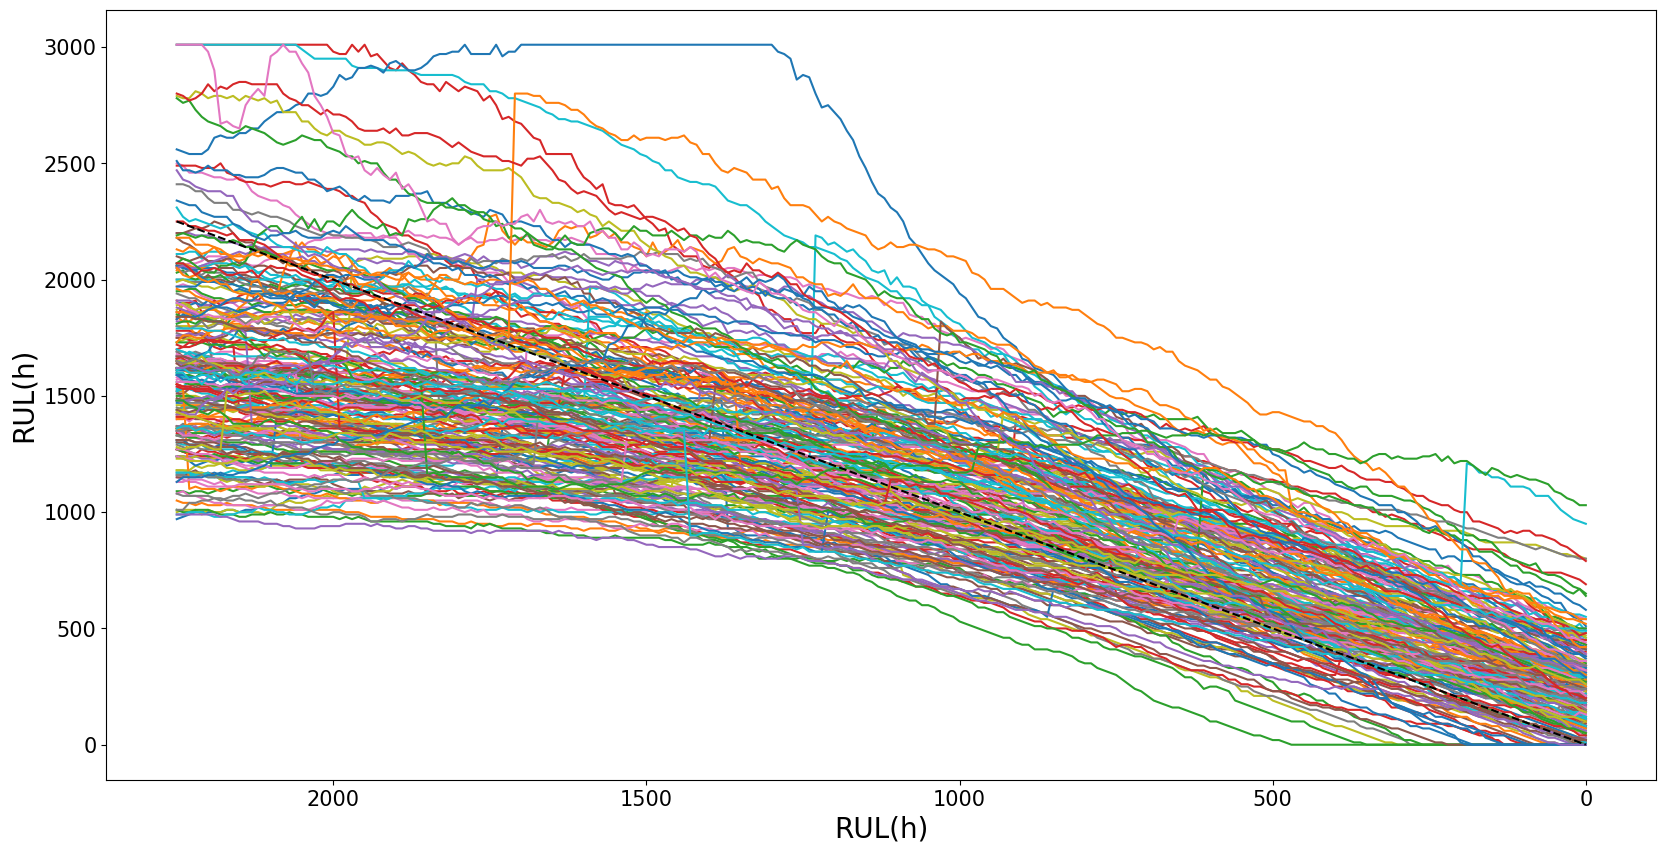

In [25]:
#plt.subplots(figsize=(28, 15))
true=np.array(range(10*(life-1),-1,-10))
plt.subplots(figsize=(20, 10))
plt.plot(np.tile(true,(y_pred_sep.shape[0],1)).T,10*y_pred_sep.T)
#plt.plot(np.tile(true,(y_true.shape[0],1)).T,y_true.T,color='black')
plt.plot(true,true,linestyle='dashed',color='black')
plt.gca().invert_xaxis()
#plt.title('Predictions')
plt.xlabel('RUL(h)',fontsize=20)
plt.ylabel('RUL(h)',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
#plt.savefig(plot_address+f'/Overal_pred_grouped.png')
plt.show()

# Individual Plots 

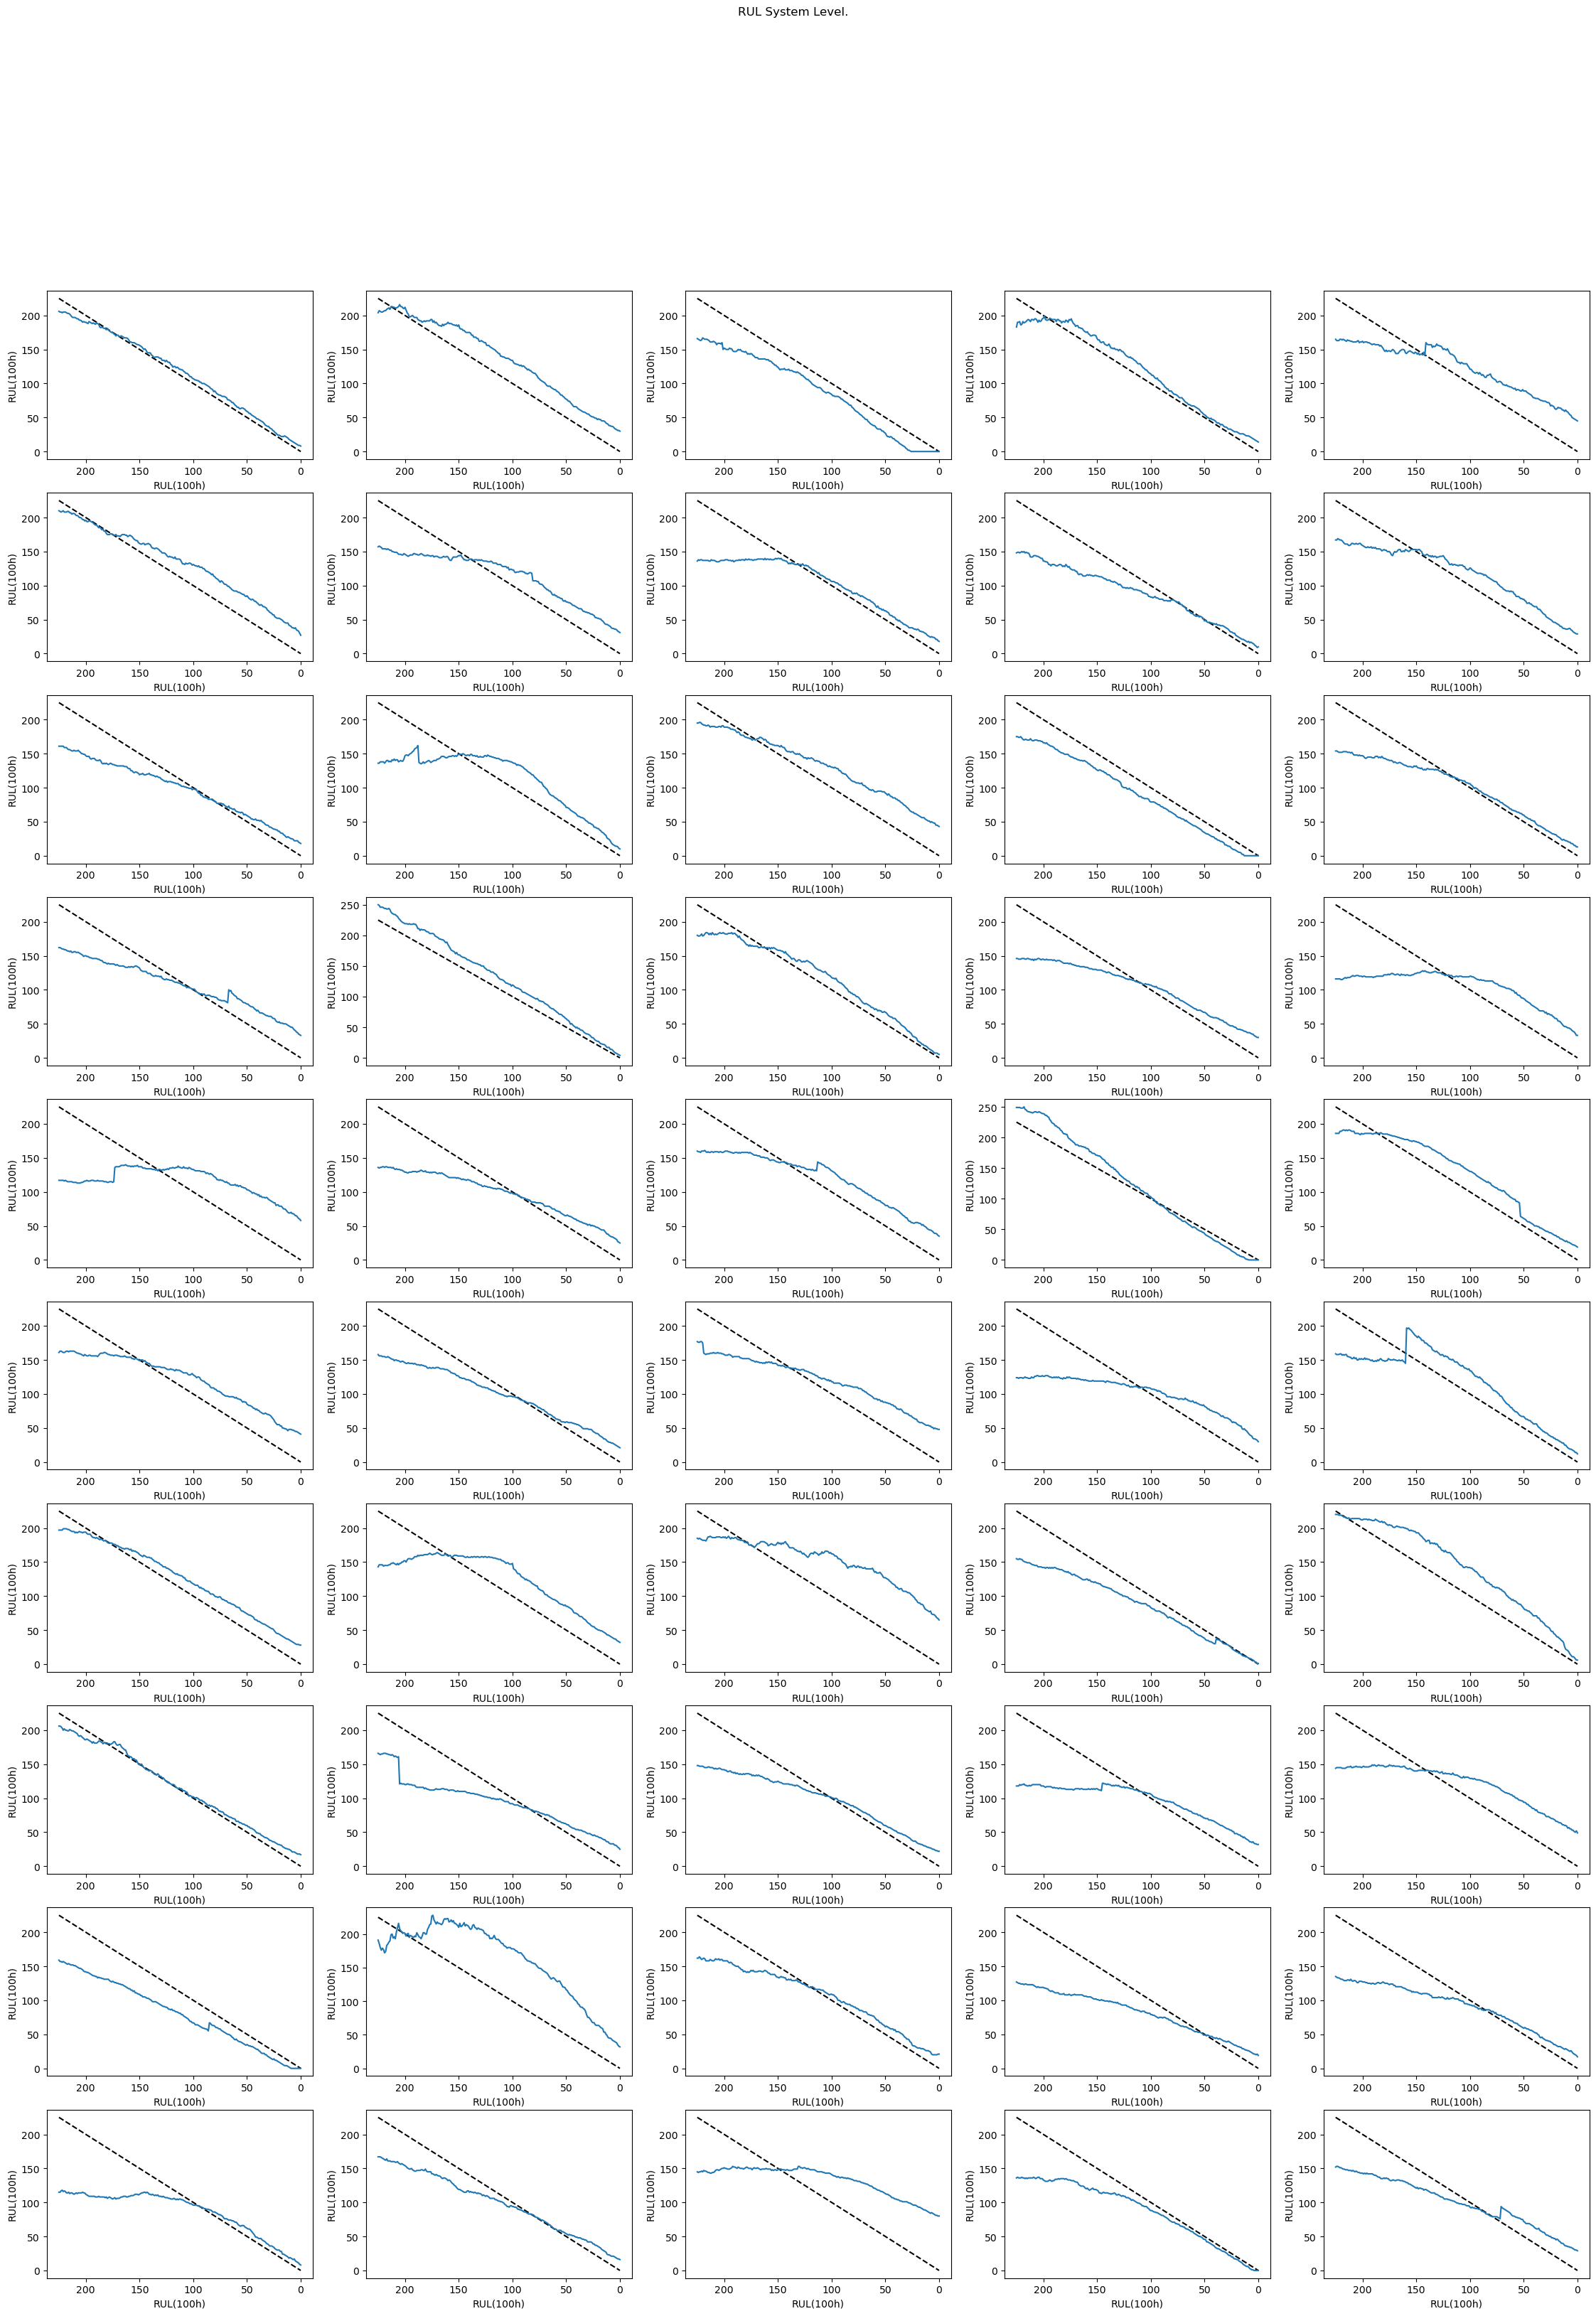

In [29]:
fig=plt.figure(figsize=(28, 40))
fig.suptitle(f'RUL System Level.')  
n_sys= y_pred_sep.shape[0] 
n_sys=50
for i in range(n_sys):#
    y_sys= y_pred_sep[i+50][np.logical_not(np.isnan(y_pred_sep[i]))]
    ax = fig.add_subplot(n_sys//5+1,5,i+1)
    ax.plot(range(y_sys.shape[0]-1,-1,-1),np.array(range(y_sys.shape[0]-1,-1,-1)),linestyle='dashed',color='black',label=f'True RUL')
    ax.plot(range(y_sys.shape[0]-1,-1,-1),y_sys,label=f'System {sys}')
    #ax.set_title(f'Prediction system {sys}')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.invert_xaxis()
#plt.savefig(plot_address+f'/Overall_pred_individual.png')
plt.show()

# Cheking Examples

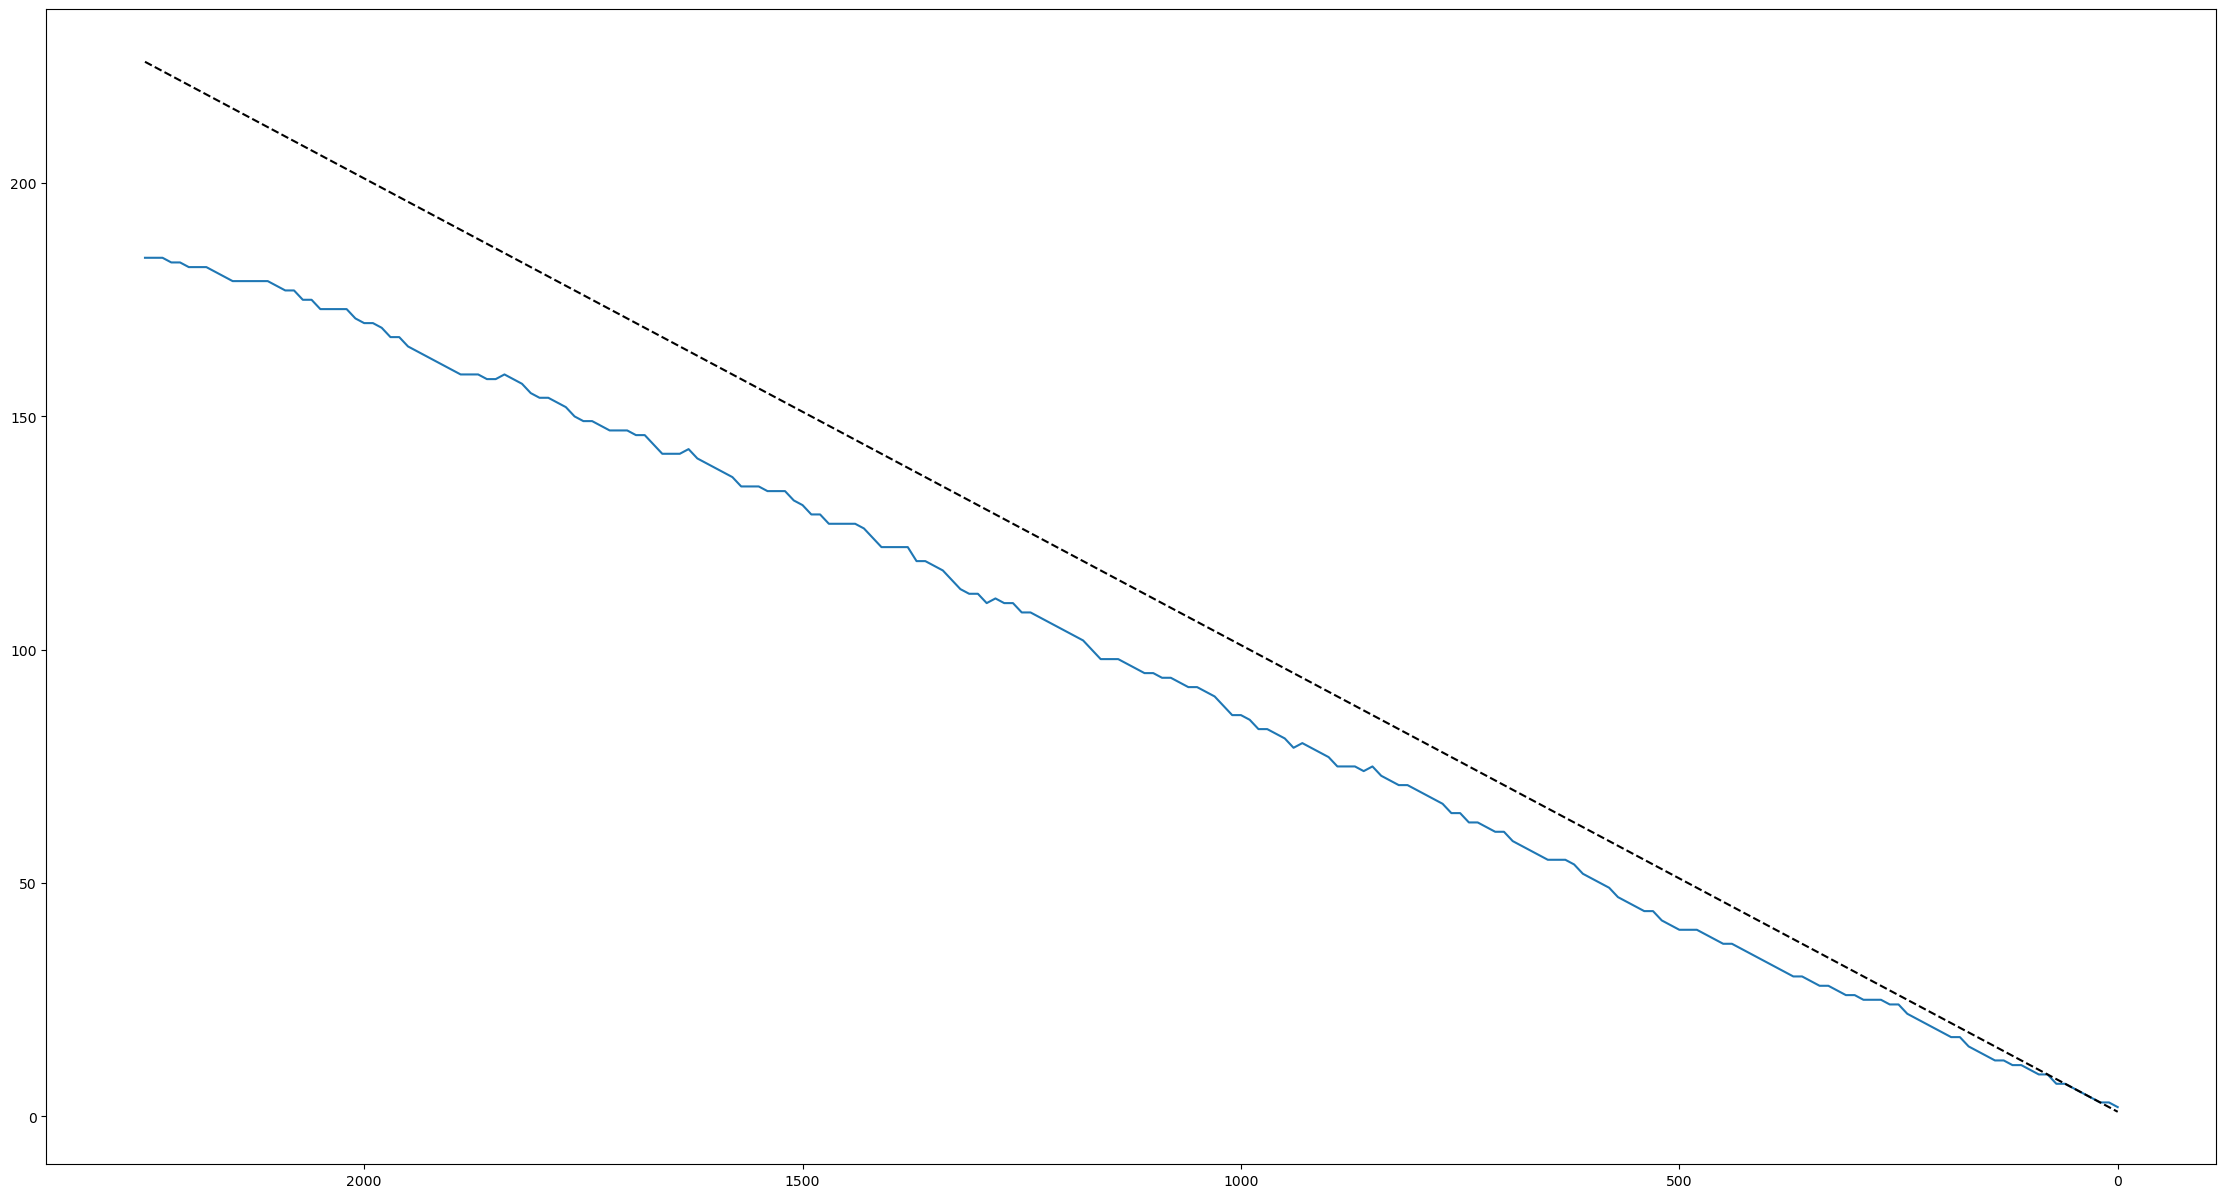

In [27]:
plt.figure(figsize=(28, 15))
for i in range(195,196):
    plt.plot(true,y_pred_sep[i].T)
    plt.plot(true,y_true_sep[i].T,linestyle='dashed',color='black')
plt.gca().invert_xaxis()  
plt.show()

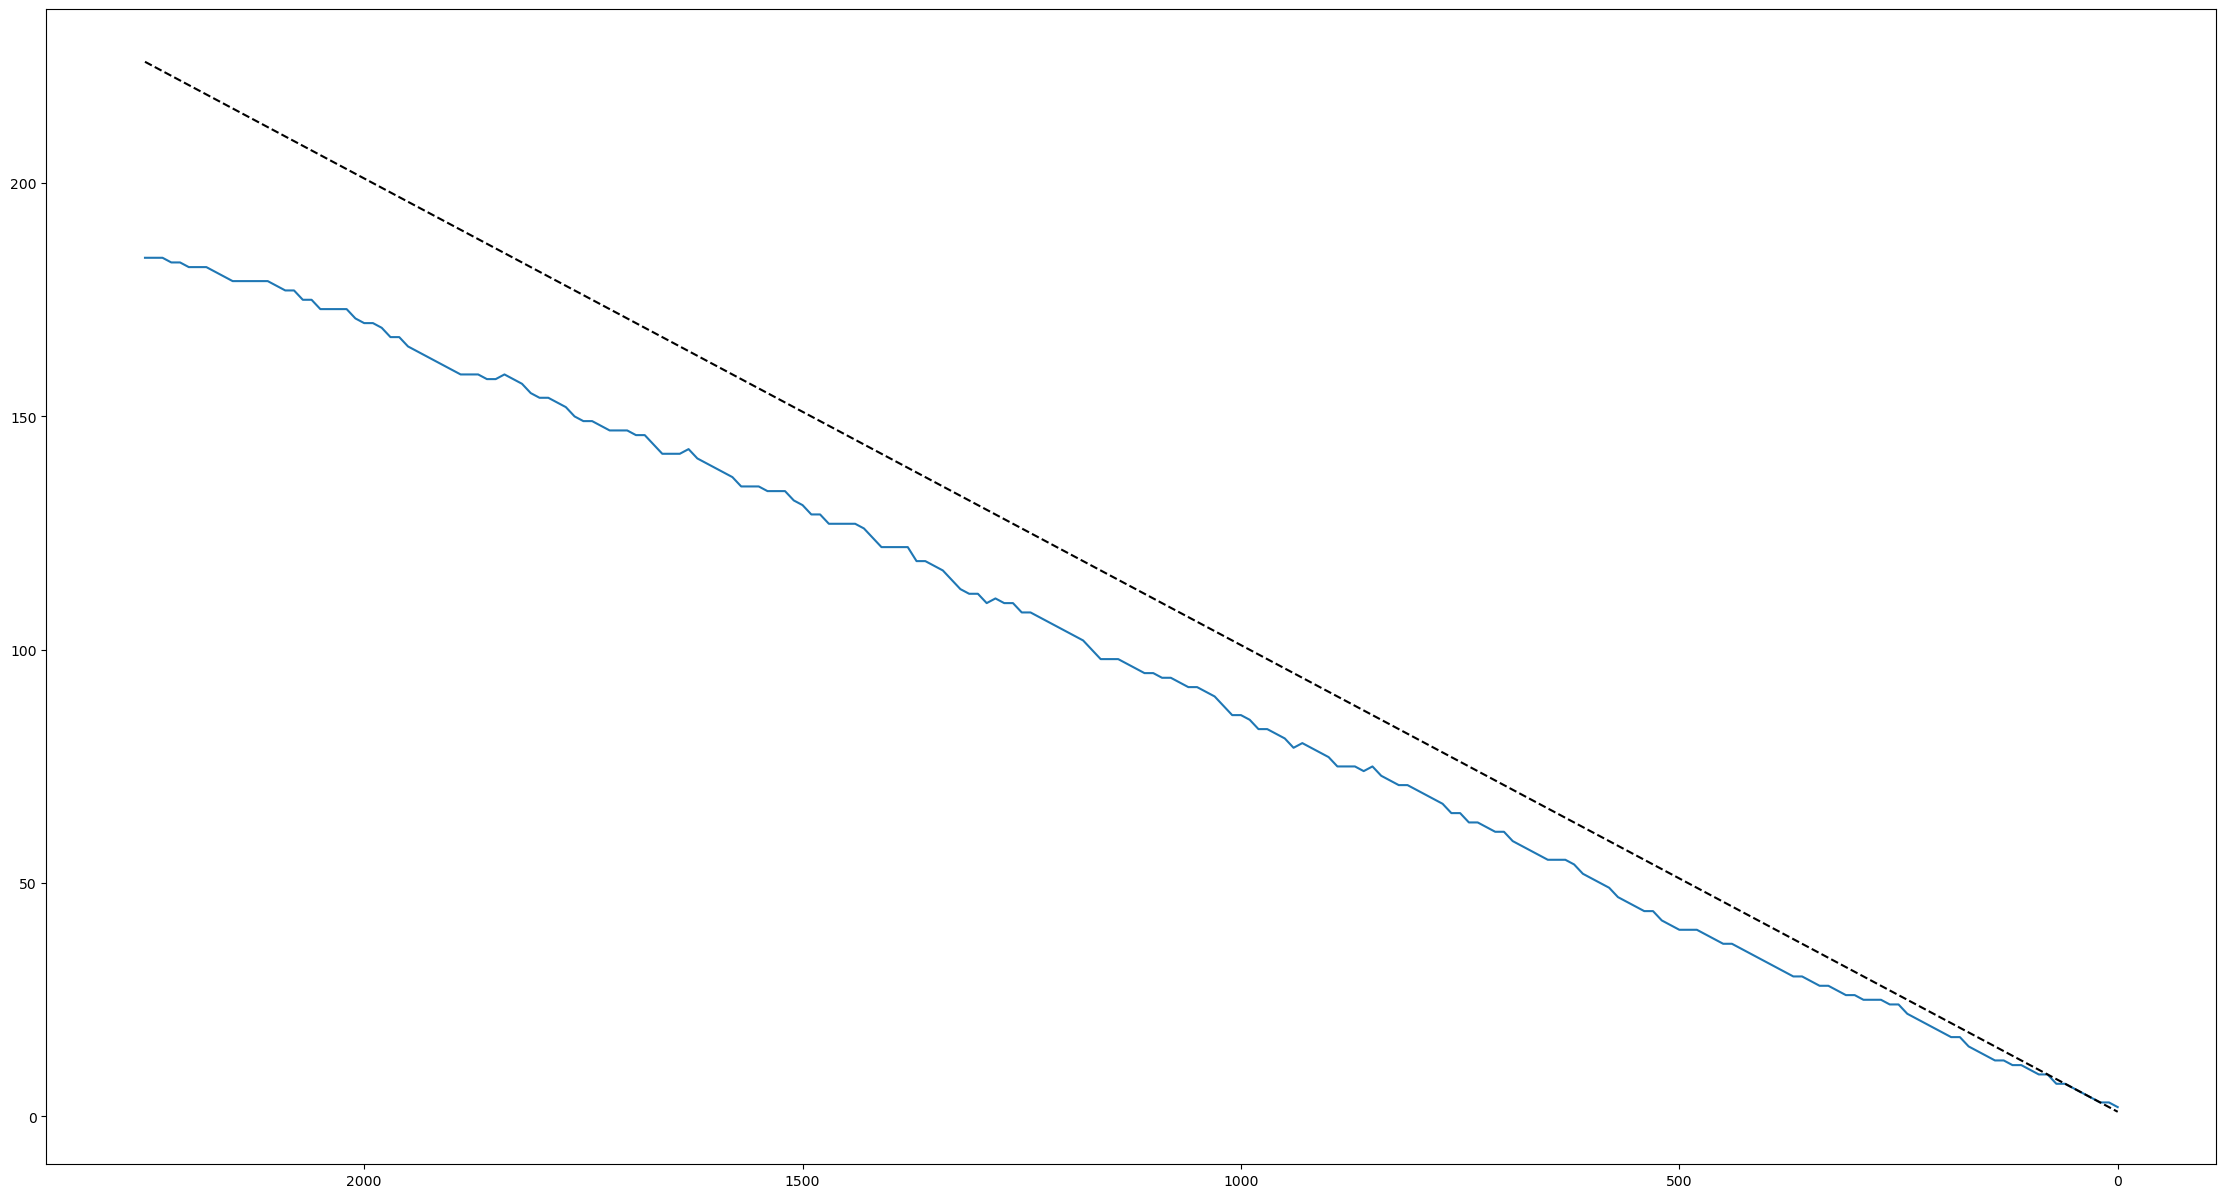

In [28]:
plt.figure(figsize=(28, 15))
for i in range(195,196):
    plt.plot(true,y_pred_sep[i].T)
    plt.plot(true,y_true_sep[i].T,linestyle='dashed',color='black')
plt.gca().invert_xaxis()  
plt.show()